In [72]:
import numpy as np
import torch
from torch import optim, nn
import copy
from tqdm import tqdm
import scipy.stats as st
from pytorch_utils.nb_figure import NBFigure
import imageio
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from cycler import cycler
import matplotlib.cm as cm
from matplotlib.cm import get_cmap
import warnings
warnings.filterwarnings("ignore")

In [43]:
class Scale(nn.Module):
    """Scale the output of the model by alpha."""

    def __init__(self, model, alpha):
        super().__init__()
        self.model = model
        self.alpha = alpha

    def forward(self, inp):
        return self.alpha*self.model(inp)

In [44]:
ACTS = {
    'relu': nn.ReLU,
    'tanh': nn.Tanh
}

In [66]:
class ZeroOutput(nn.Module):
    """Zero the output of a model by subtracting out a copy of it."""

    def __init__(self, model):
        super().__init__()
        self.init_model = [copy.deepcopy(model).eval()]

        self.model = model

    def forward(self, inp):
        return self.model(inp) - self.init_model[0](inp)

In [45]:
def simple_net(width,
               bias=True,
               zero_output=True,
               alpha=1,
               hidden_layers=1,
               act='relu',
               **kwargs):
    """A simple 1d input to 1d output deep ReLU network.

    Parameters
    ----------
    bias : bool
        Whether to include biases.
    zero_output : bool
        Whether to zero the output of the model.
    alpha : float
        Scale of output.
    """
    a = ACTS[act]
    model = nn.Sequential(nn.Linear(1, width, bias=bias),
                          a(),
                          *[layer
                            for _ in range(hidden_layers-1)
                            for layer in [nn.Linear(width, width, bias=bias), a()]
                            ],
                          nn.Linear(width, 1, bias=bias))

    if zero_output:
        model = ZeroOutput(model)
    model = Scale(model, alpha)
    return model

In [46]:
def ntk(model, inp):
    """Calculate the neural tangent kernel of the model on the inputs.

    Returns the gradient feature map along with the tangent kernel.
    """
    out = model(inp)
    p_vec = nn.utils.parameters_to_vector(model.parameters())
    p, = p_vec.shape
    n, outdim = out.shape
    assert outdim == 1, "cant handle output dim higher than 1 for now"

    # this is the transpose jacobian (grad y(w))^T)
    features = torch.zeros(n, p, requires_grad=False)

    for i in range(n):  # for loop over data points
        model.zero_grad()
        out[i].backward(retain_graph=True)
        p_grad = torch.tensor([], requires_grad=False)
        for p in model.parameters():
            p_grad = torch.cat((p_grad, p.grad.reshape(-1)))
        features[i, :] = p_grad

    tk = features @ features.t()  # compute the tangent kernel
    return features, tk

In [47]:
def gd(model, xdata, ydata,
       iters=100,
       lr=1e-3,
       alpha=1,
       save_every=-1,
       ex=None,
       run_dir='.',
       progress_bar=True,
       eps=1e-10):
    """Run gradient descent using square loss on the model with the given data.

    Updates the given model instance.

    Parameters
    ----------
    alpha : float
        Scaling factor to normalize by. The loss is divided by alpha^2.
    save_every : int
        Interval with which to save model instances.
    ex : Sacred experiment
        Experiment to use for logging and saving.
    run_dir : str
        Path of directory to save models.
    eps : float
        Stop if the loss reduces below this value.

    Returns
    -------
    list of loss values

    """

    opt = optim.SGD(model.parameters(), lr=lr)
    losses = []

    if ex != None:
        run_dir = get_run_dir(ex)

    litem = -1
    t = range(iters)
    if progress_bar:
        t = tqdm(t)
    for i in t:
        if save_every != -1 and i % save_every == 0:
            # torch.save(model.state_dict(),
            #            f"{run_dir}/{i:06d}_model_{litem:.4f}.statedict")
            fname = f"{run_dir}/{i:06d}_model_{litem:.4f}.model"
            torch.save(model.eval(), fname)
            # ex.add_artifact(fname, f"{i:06d}_model.model")

        out = model(xdata)

        # normalizing the loss:
        loss = 1/(alpha**2) * nn.MSELoss()(out, ydata)

        # we store the unnormalized losses
        litem = loss.item()*(alpha**2)
        losses.append(litem)
        if progress_bar:
            t.set_postfix(loss=litem)
        if ex != None:
            ex.log_scalar(litem, 'loss')

        if litem < eps:
            return losses
        opt.zero_grad()
        loss.backward()
        opt.step()

    return losses

In [48]:
DEFAULT_COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

def reset_colors():
    plt.rc('axes', prop_cycle=cycler(color=DEFAULT_COLORS))    

def set_colors(count):
    colors = [get_cmap('inferno')(1. * i/count) for i in range(count)][::-1]
    plt.rc('axes', prop_cycle=cycler(color=colors))

In [49]:
x = torch.linspace(-5, 5, 5000).unsqueeze(1)

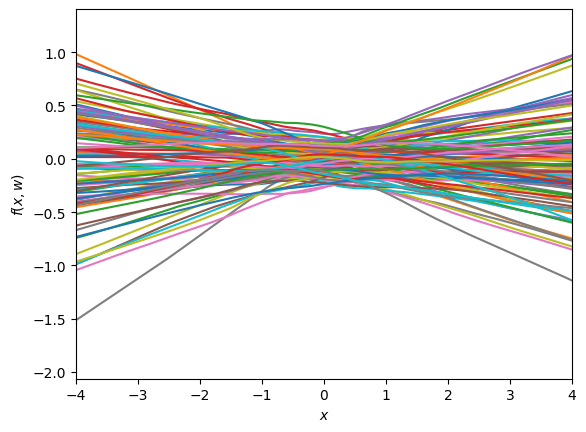

In [50]:
reset_colors()
m = 100
b = True
count = 100
for i in range(count):
    f = simple_net(width=m, bias=b, alpha=1, zero_output=False, hidden_layers=2)
    plt.plot(x.detach(), f(x).detach())
plt.xlabel("$x$")
plt.ylabel("$f(x, w)$")
# ylim(-4, 4)
plt.xlim(-4, 4)
# savefig("net_funcs.png", bbox_inches='tight')
plt.show()

In [51]:
xin = torch.tensor([-3, 0.5]).unsqueeze(1)
yin = torch.tensor([2, -1.0]).unsqueeze(1)

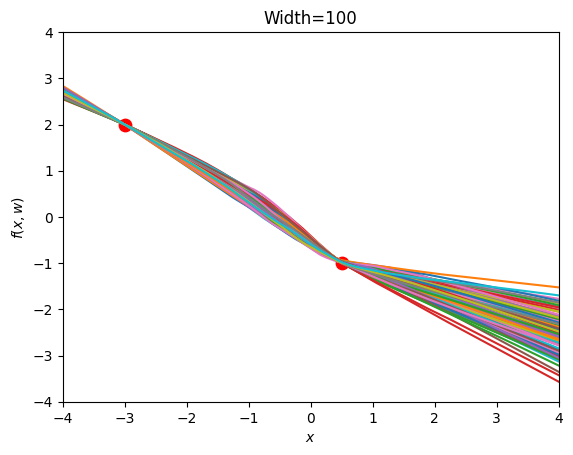

In [52]:
nbf = NBFigure('train_fig.png')
ax = nbf.getAxis()
nbf.set_xlim((-4, 4))
nbf.set_ylim((-4, 4))
nbf.display()
nbf.update()

In [53]:
m = 100
b = True
count = 100
depth = 2
alpha = 1
all_nets = [simple_net(width=m, bias=b, alpha=alpha, zero_output=False, hidden_layers=depth) for _ in range(count)]
tk0s = [ntk(net, xin)[1] for net in all_nets]
lines = []
for net in all_nets:
    l, = ax.plot(x.detach(), net(x).detach())
    lines.append(l)
ax.scatter(xin, yin, color='red', s=80)
ax.set_title(f"Width={m}")
ax.set_xlabel("$x$")
ax.set_ylabel("$f(x, w)$")
nbf.update()
im0 = imageio.imread('train_fig.png')

In [54]:
iters = 100
steps_per_iter = 5
lr = 1e-3
imgs = []
for i in tqdm(range(iters)):
    for line, net in zip(lines, all_nets):
        gd(net, xin, yin, alpha=alpha, iters=steps_per_iter, lr=lr, progress_bar=False)
        line.set_data(x.detach(), net(x).detach())
    nbf.update()
    imgs.append(imageio.imread('train_fig.png'))

100%|█████████████████████████████████████████| 100/100 [06:14<00:00,  3.75s/it]


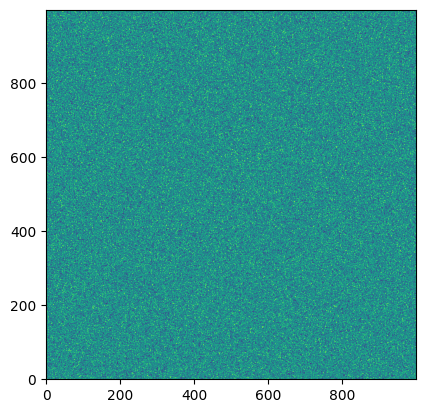

In [55]:
nbf = NBFigure('single_train.png')
ax = nbf.getAxis()
# nbf.set_xlim((-5, 5))
# nbf.set_ylim((-4, 4))
nbf.display()
nbf.update()

In [56]:
xs = {}
budges = {}
losses = {}

In [57]:
gif = True # False for faster training, if true will be slower but live updates the above figure
plot_count = 0
eps = 1e-10
iters = 1000
steps_per_iter = 1
lr = 1e-3

In [60]:
for m in [100, 1000]:
    f = simple_net(width=m, bias=True, alpha=1, zero_output=False, hidden_layers=2)
    A0, tk0 = ntk(f, xin)
    weights0 = list(f.modules())[4].weight.detach().numpy().copy()
    allw0 = nn.utils.parameters_to_vector(f.parameters()).detach().numpy().copy()
    if gif:
        im = ax.imshow(weights0)
        nbf.update()

    imgs = []
    imgs2 = []
    xvals = [0]
    budgevals = [0]
    lossvals = []
    t = tqdm(range(iters), desc=f'm={m}')
    for i in t:
        ls = gd(f, xin, yin, alpha=1, iters=steps_per_iter, lr=lr, progress_bar=False)
        lossvals.extend(ls)
        t.set_postfix(loss=ls[-1])
    #     l.set_data(x.detach(), f(x).detach())
        weights = list(f.modules())[4].weight.detach().numpy().copy()
        allw = nn.utils.parameters_to_vector(f.parameters()).detach().numpy().copy()
        budge = budge = np.linalg.norm(allw - allw0) / np.linalg.norm(allw0)
        xvals.append((i+1)*steps_per_iter)
        budgevals.append(budge)
        if gif:
            im.set_data(weights)
            nbf.update()
            imgs.append(imageio.imread('single_train.png'))
        if ls[-1]<eps:
            break
    
    xs[m] = xvals.copy()
    budges[m] = budgevals.copy()
    losses[m] = lossvals.copy()

m=1000:  19%|███▏             | 187/1000 [00:19<01:23,  9.75it/s, loss=9.97e-11]


In [61]:
np.linalg.norm(weights - weights0) / np.linalg.norm(weights0)

0.0074379523

In [62]:
A1, tk1 = ntk(f, xin)
print(np.linalg.norm(tk1-tk0)/np.linalg.norm(tk0))

0.098990485


100%|█████████████████████████████████████████████| 7/7 [00:24<00:00,  3.45s/it]

alpha		relative change in tk norm
1.0000e-02	124.38017272949219
6.8129e-02	24.124896240234374
4.6416e-01	2.266147255897522
3.1623e+00	0.06751443073153496
2.1544e+01	0.008097201655618846
1.4678e+02	0.004904386788257398
1.0000e+03	8.899509421098629e-05



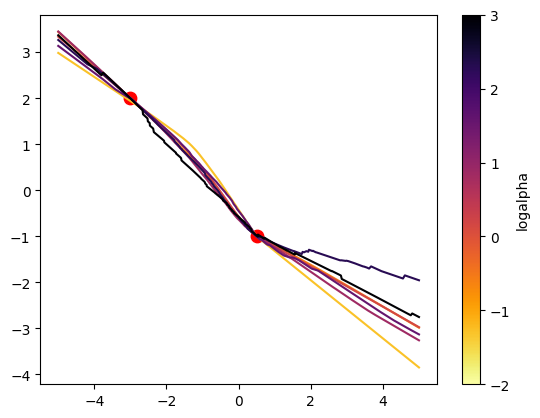

In [74]:
m = 100
depth = 2
logalphas = np.linspace(-2, 3, 7)
trials = 5
alphas = 10**logalphas
b=True

set_colors(len(alphas))

dels = []
out = ""
for alpha in tqdm(alphas):
    del_dh = 0
    for k in range(trials):
        f = simple_net(width=m, bias=b, alpha=alpha, zero_output=True, hidden_layers=depth)
        A0, tk0 = ntk(f, xin)
        gd(f, xin, yin, alpha=alpha, iters=4000, lr=3e-4, progress_bar=False)
        A1, tk1 = ntk(f, xin)
        y = f(x)
        del_dh += np.linalg.norm(tk1-tk0)/np.linalg.norm(tk0)
    dels.append(del_dh/trials)
    out += f"{alpha:.4e}\t{del_dh/trials}\n"
    plt.plot(x.detach(), y.detach())

print("alpha\t\trelative change in tk norm")
print(out)
sm = cm.ScalarMappable(cmap=get_cmap('inferno_r'), norm=Normalize(vmin=logalphas[0], vmax=logalphas[-1]))
sm._A=[]
plt.colorbar(sm, label='logalpha')

plt.scatter(xin, yin, color='red', s=80)
plt.show()